# Preparing the environment


## Libraries

In [25]:
#%pip install adjustText

In [26]:
# requirements
import pandas as pd
import scripts.eta_analysis as eta
import scripts.ra_analysis as ra
import numpy as np
import plotly.graph_objects as go

## Results Analysis

Load the resulting datasets from experiment phase.

In [27]:
df_eta = pd.read_csv("../2-experiments/outputs/kalman_eta_results.csv")
df_k = pd.read_csv("../2-experiments/outputs/kalman_k_results.csv")
df_q = pd.read_csv("../2-experiments/outputs/kalman_q_results.csv")
df_r = pd.read_csv("../2-experiments/outputs/kalman_r_results.csv")
df_ra_win = pd.read_csv("../2-experiments/outputs/kalman_ra_win_results.csv")
anomalous_traffic_win_observations_df = pd.read_csv(
    "../0-datasets/treated_dataset/anomalous_traffic_win_observations.csv")

Converting the timestamp column to datetime, easing it manipulation and aritmetics.

In [28]:
df_k['window_start'] = pd.to_datetime(df_k['window_start'])
df_q['window_start'] = pd.to_datetime(df_q['window_start'])
df_r['window_start'] = pd.to_datetime(df_r['window_start'])
df_ra_win['window_start'] = pd.to_datetime(df_ra_win['window_start'])
anomalous_traffic_win_observations_df['time_local'] = pd.to_datetime(anomalous_traffic_win_observations_df['time_local'])

### $\eta$ evaluation

In [29]:
df_eta_metrics = eta.compute_classification_metrics(df_eta)

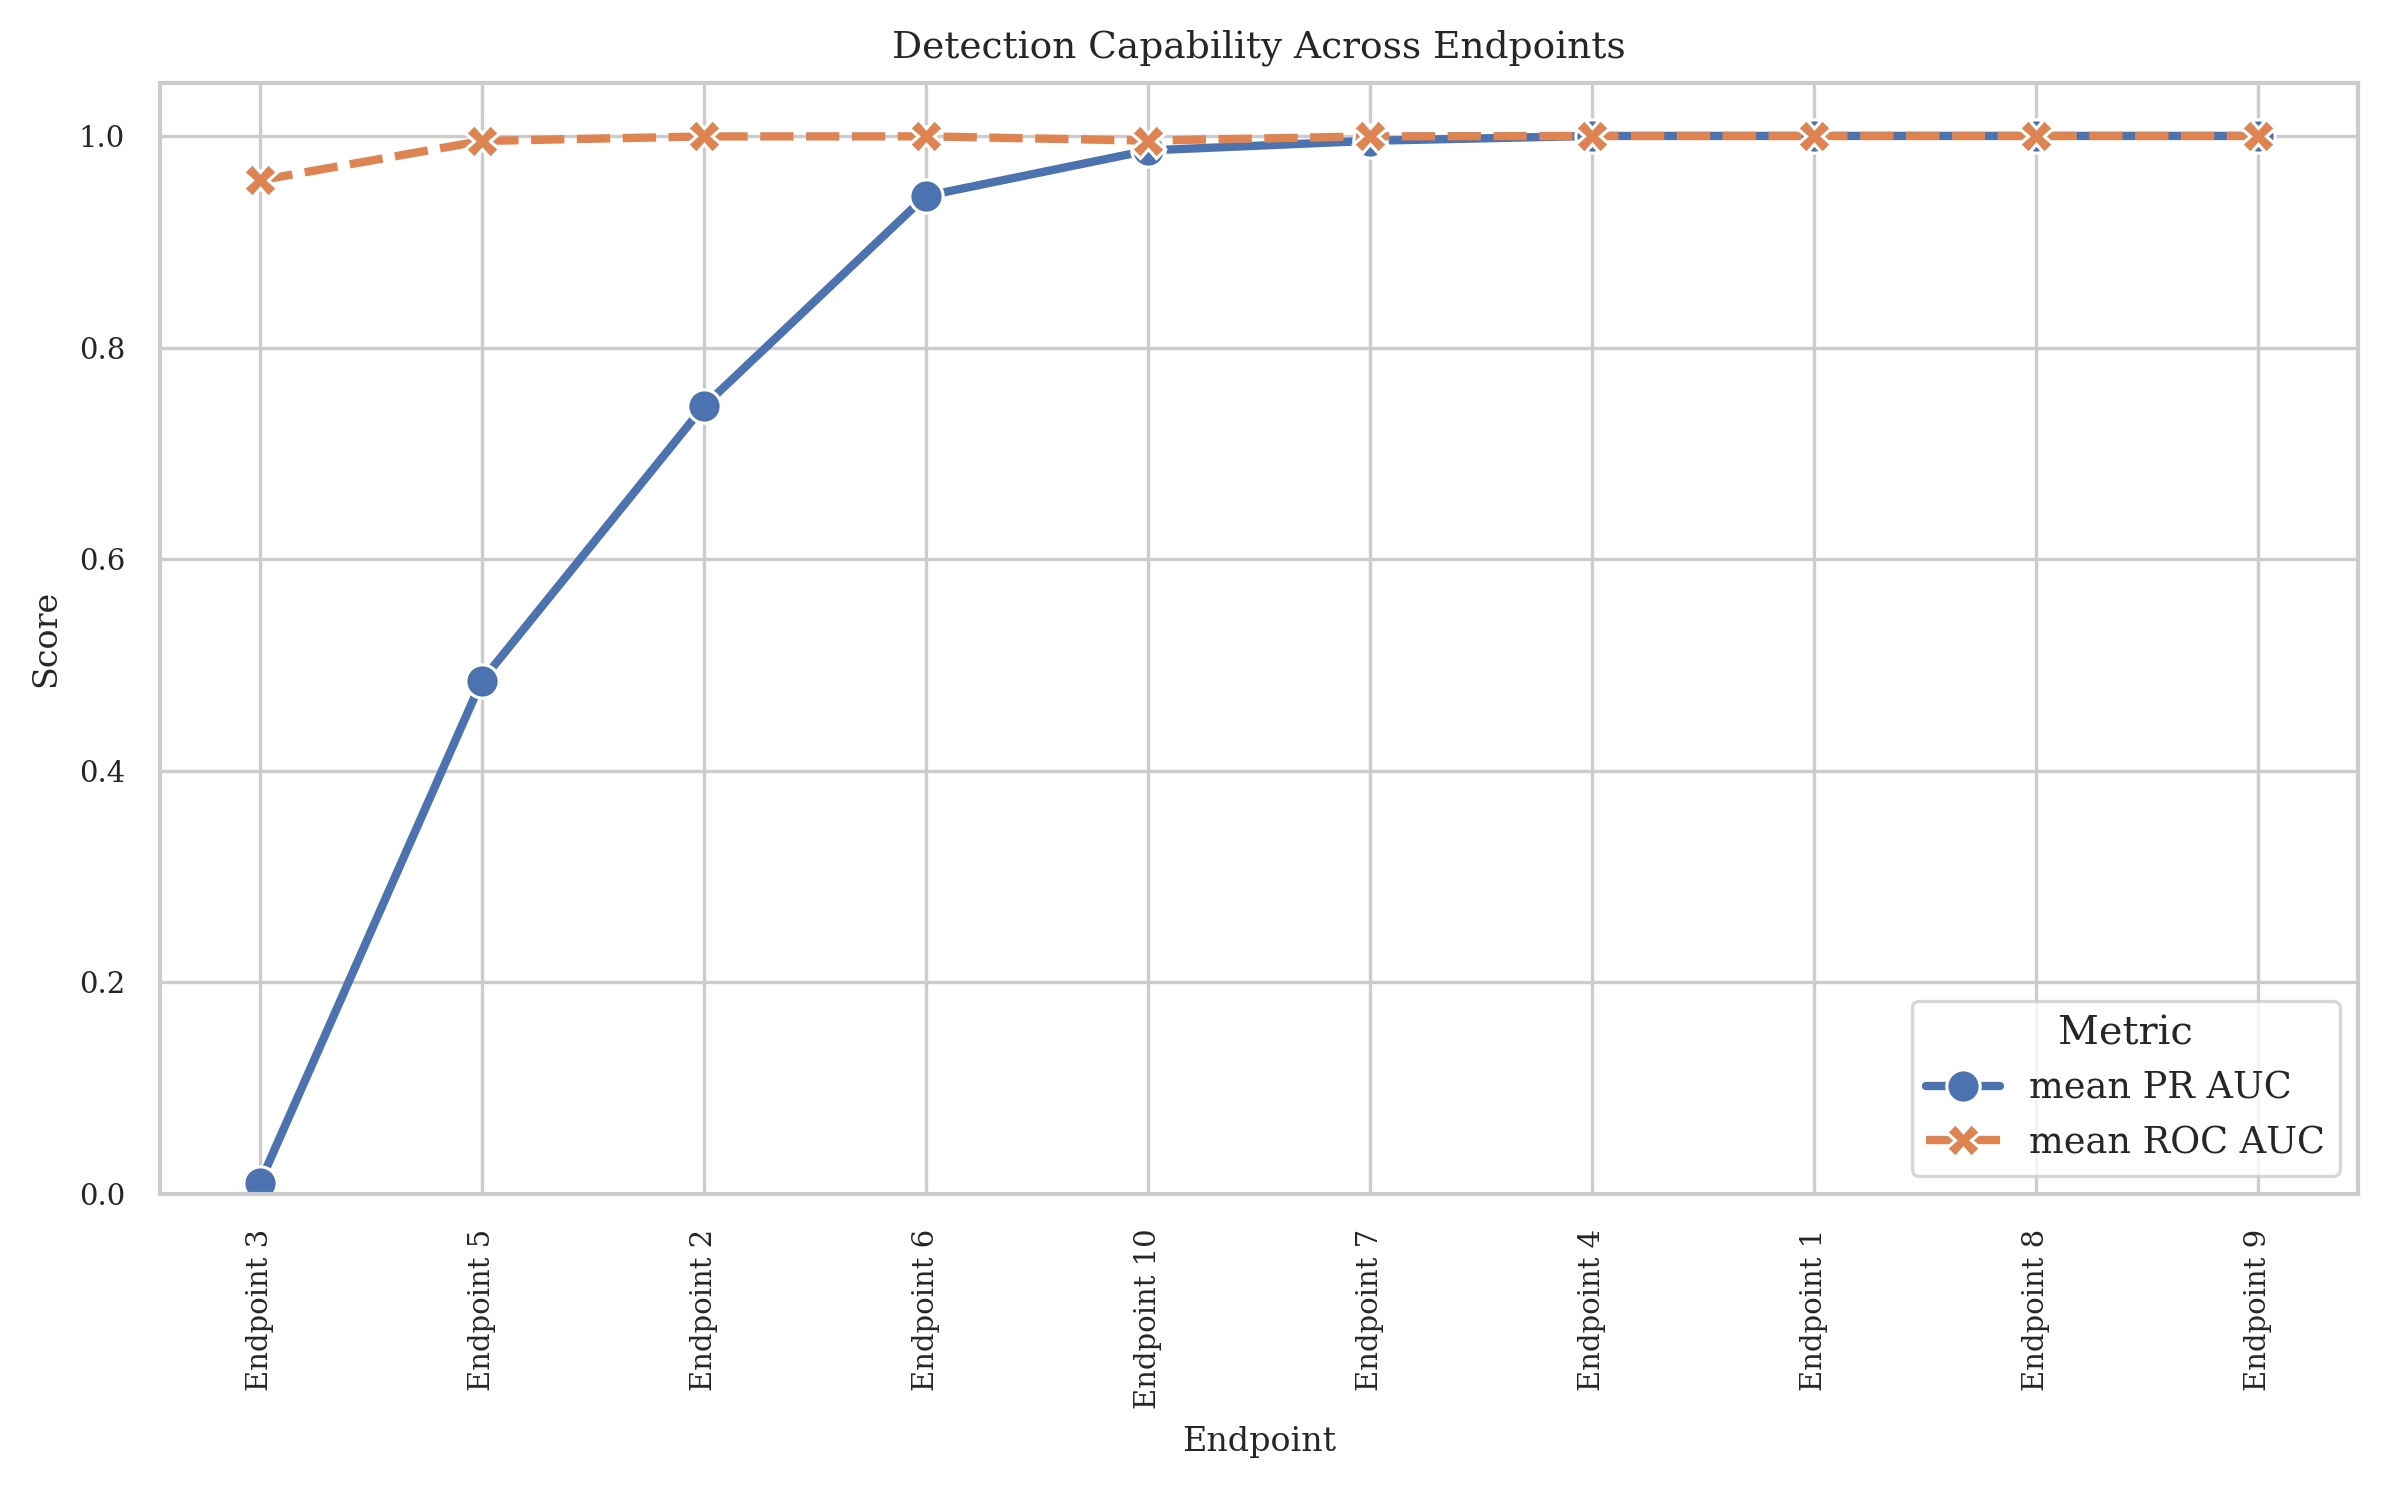

In [30]:
eta.plot_detection_capability(df_eta_metrics, figsize=(8, 5))

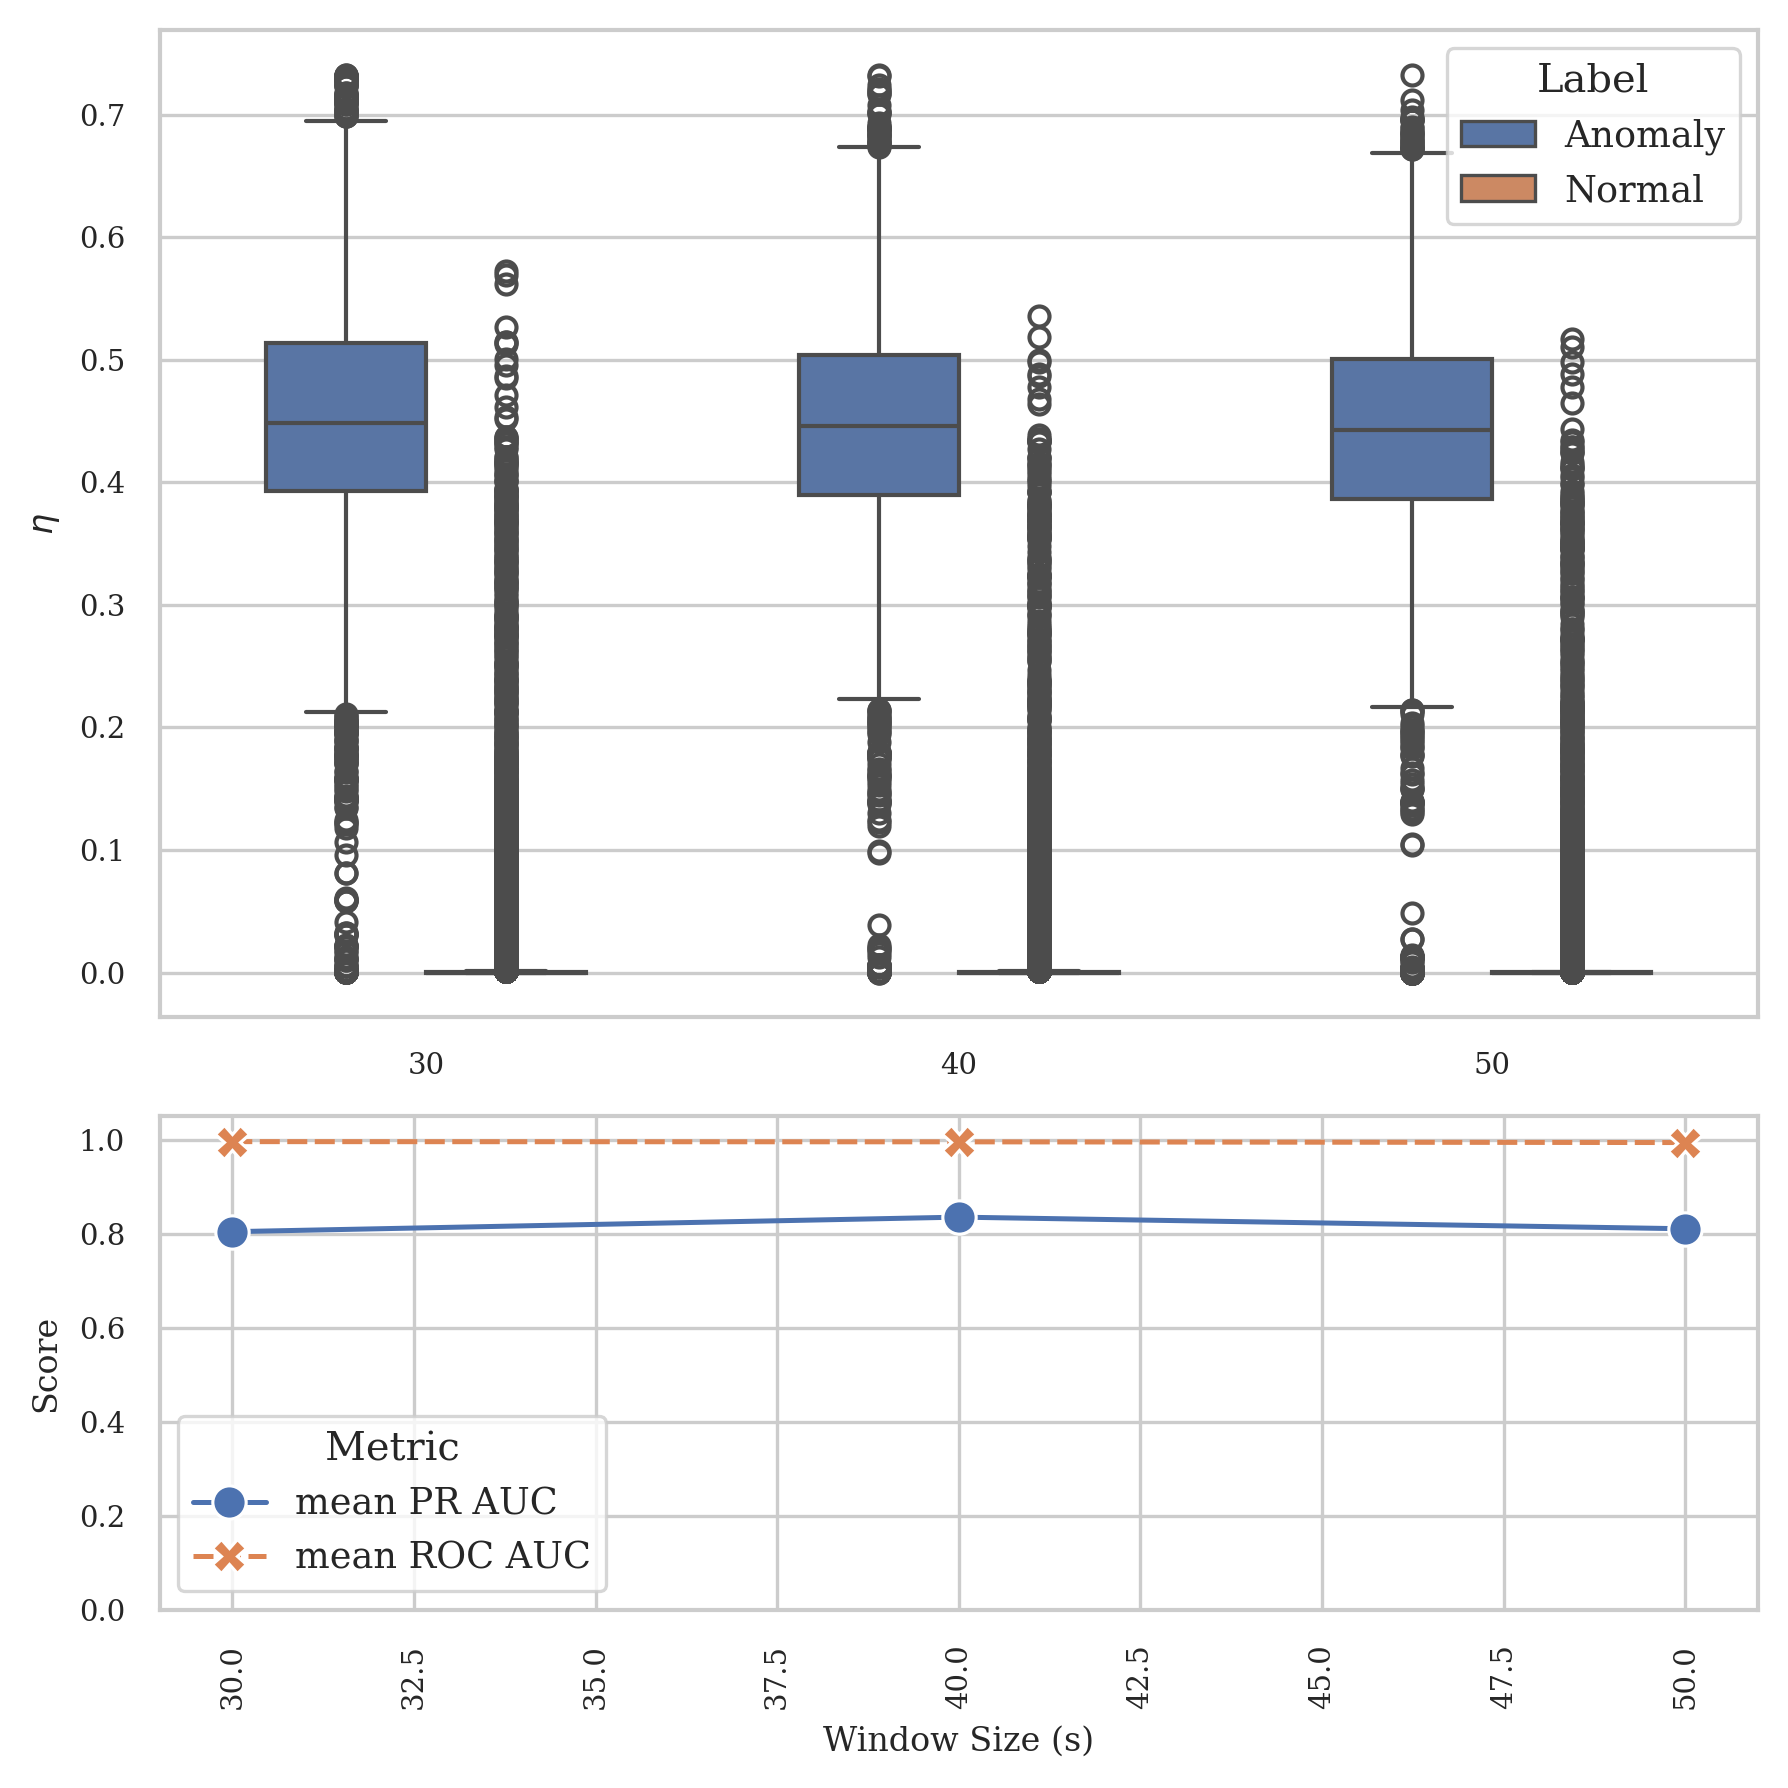

In [31]:
eta.plot_combined_analysis(df_eta_metrics, df_eta, figsize=(6, 6))

In [32]:
eta.get_summary_stats(df_eta_metrics)

,Mean,Std,Min,Max
ROC_AUC,0.994741,0.012709,0.951996,1.0
PR_AUC,0.816415,0.319150,0.008772,1.0


In [33]:
eta.get_summary_stats(df_eta_metrics, group_by=["window_size"])

window_size   ROC_AUC                             PR_AUC            \
                   mean       std       min  max      mean       std   
0          30  0.995549  0.011350  0.963442  1.0  0.804028  0.338831   
1          40  0.995103  0.012918  0.958585  1.0  0.834992  0.325184   
2          50  0.993571  0.014914  0.951996  1.0  0.810226  0.327196   

                  
        min  max  
0  0.008772  1.0  
1  0.010309  1.0  
2  0.011111  1.0

### Ra Evaluation

Sensitivity analysis was conducted by independently varying
the observation sensitivity parameter k, process noise Q,
and observation noise R, while fixing the temporal aggregation window
to 30 seconds.

A separate analysis was conducted to evaluate robustness across
different window sizes.


Measured properties:
- Sensibility: how Ra responds to anomaly
- Ratio: if Ra responds more anomalies bigger
- Memory: if Ra is integrating along the time
- Robust: if it is consistent for different values of k, Q, R

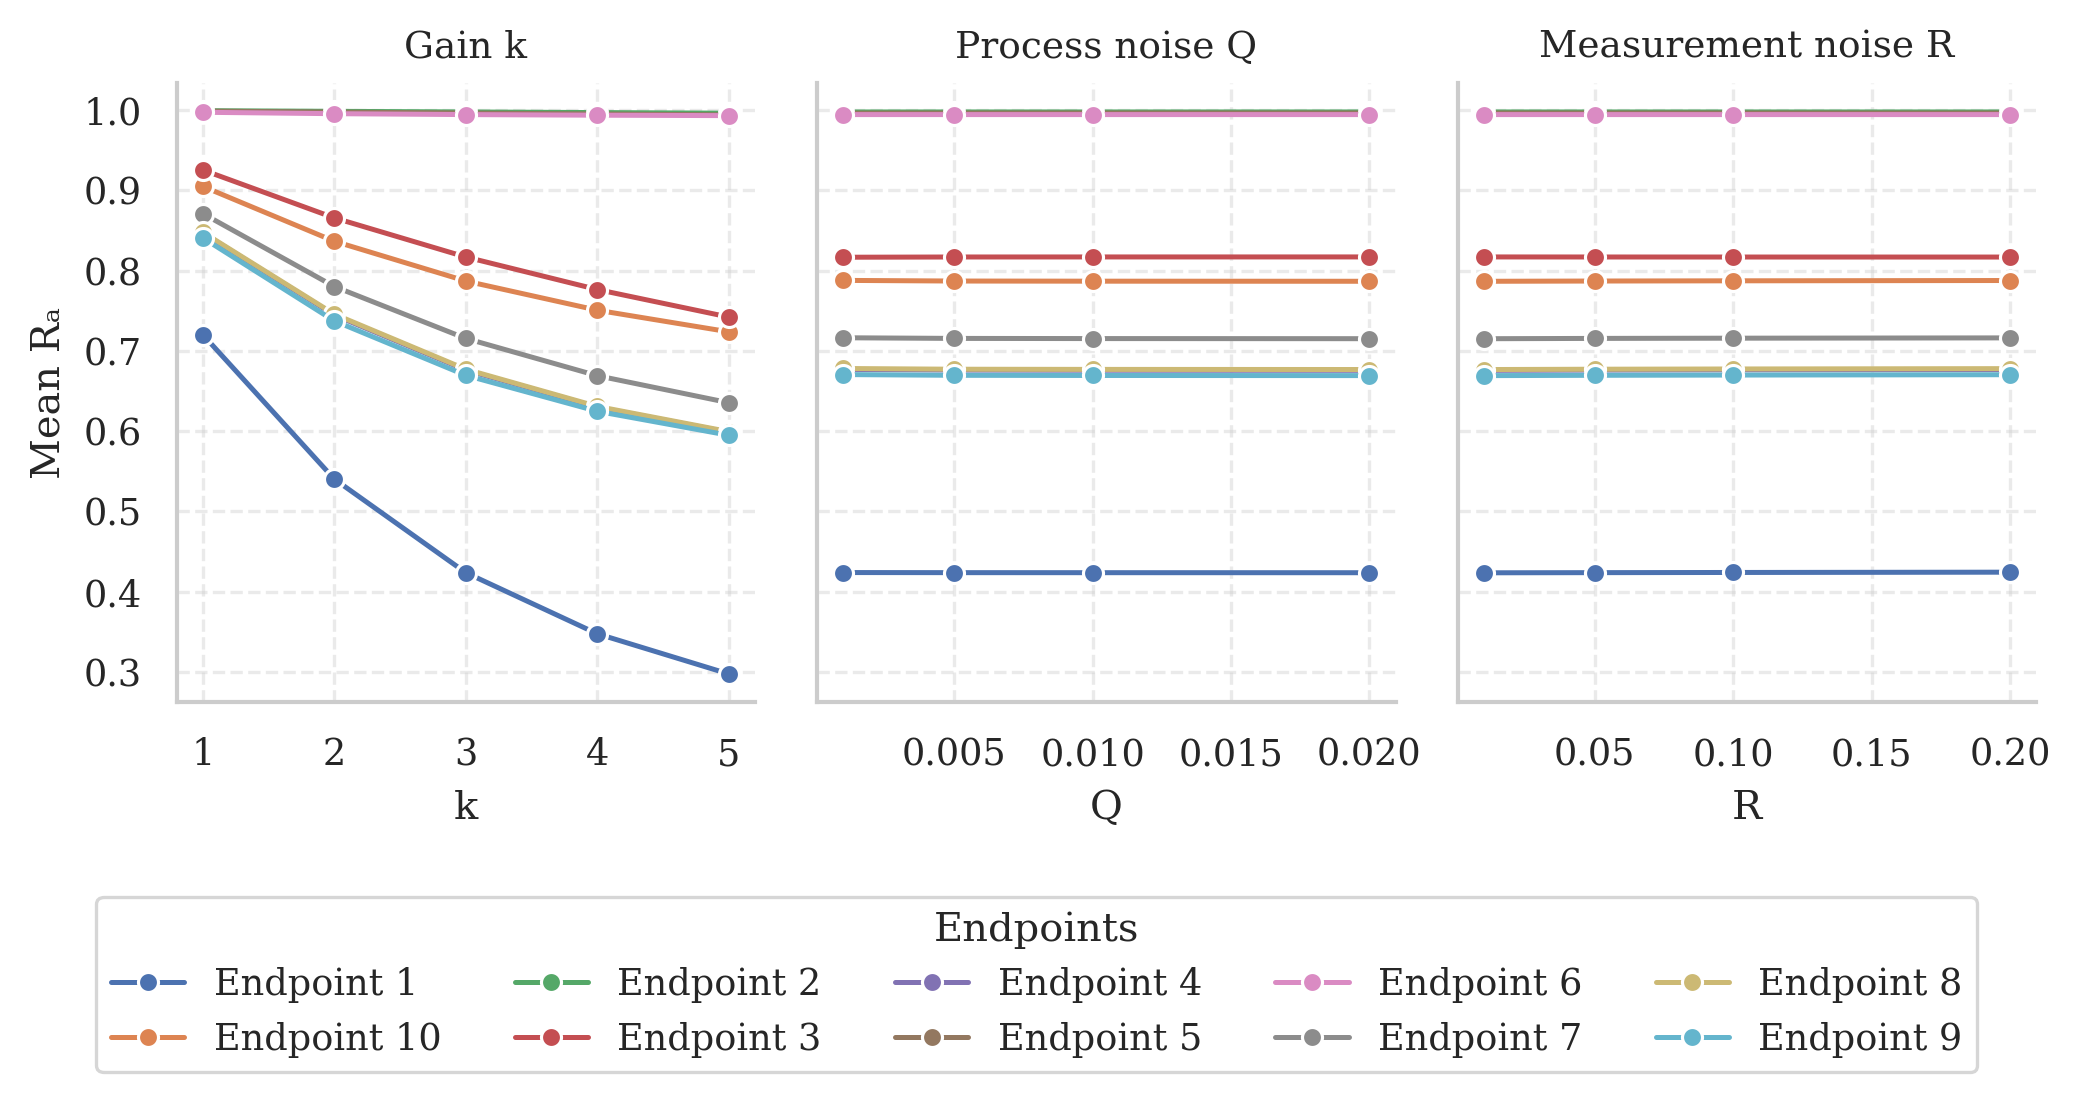

In [34]:
ra.plot_ra_vs_kalman_params_grid(df_k=df_k, df_R=df_r, df_Q=df_q)

Ra in response to anomaly events

The endpoint-specific visualization confirms that the relationship between anomaly score and health degradation is consistent across all monitored services. While minor differences in degradation magnitude are observed due to endpoint-specific traffic dynamics and anomaly persistence, all endpoints exhibit the same monotonic functional response. This demonstrates that the proposed Kalman-based health indicator is robust and generalizable across heterogeneous traffic profiles.

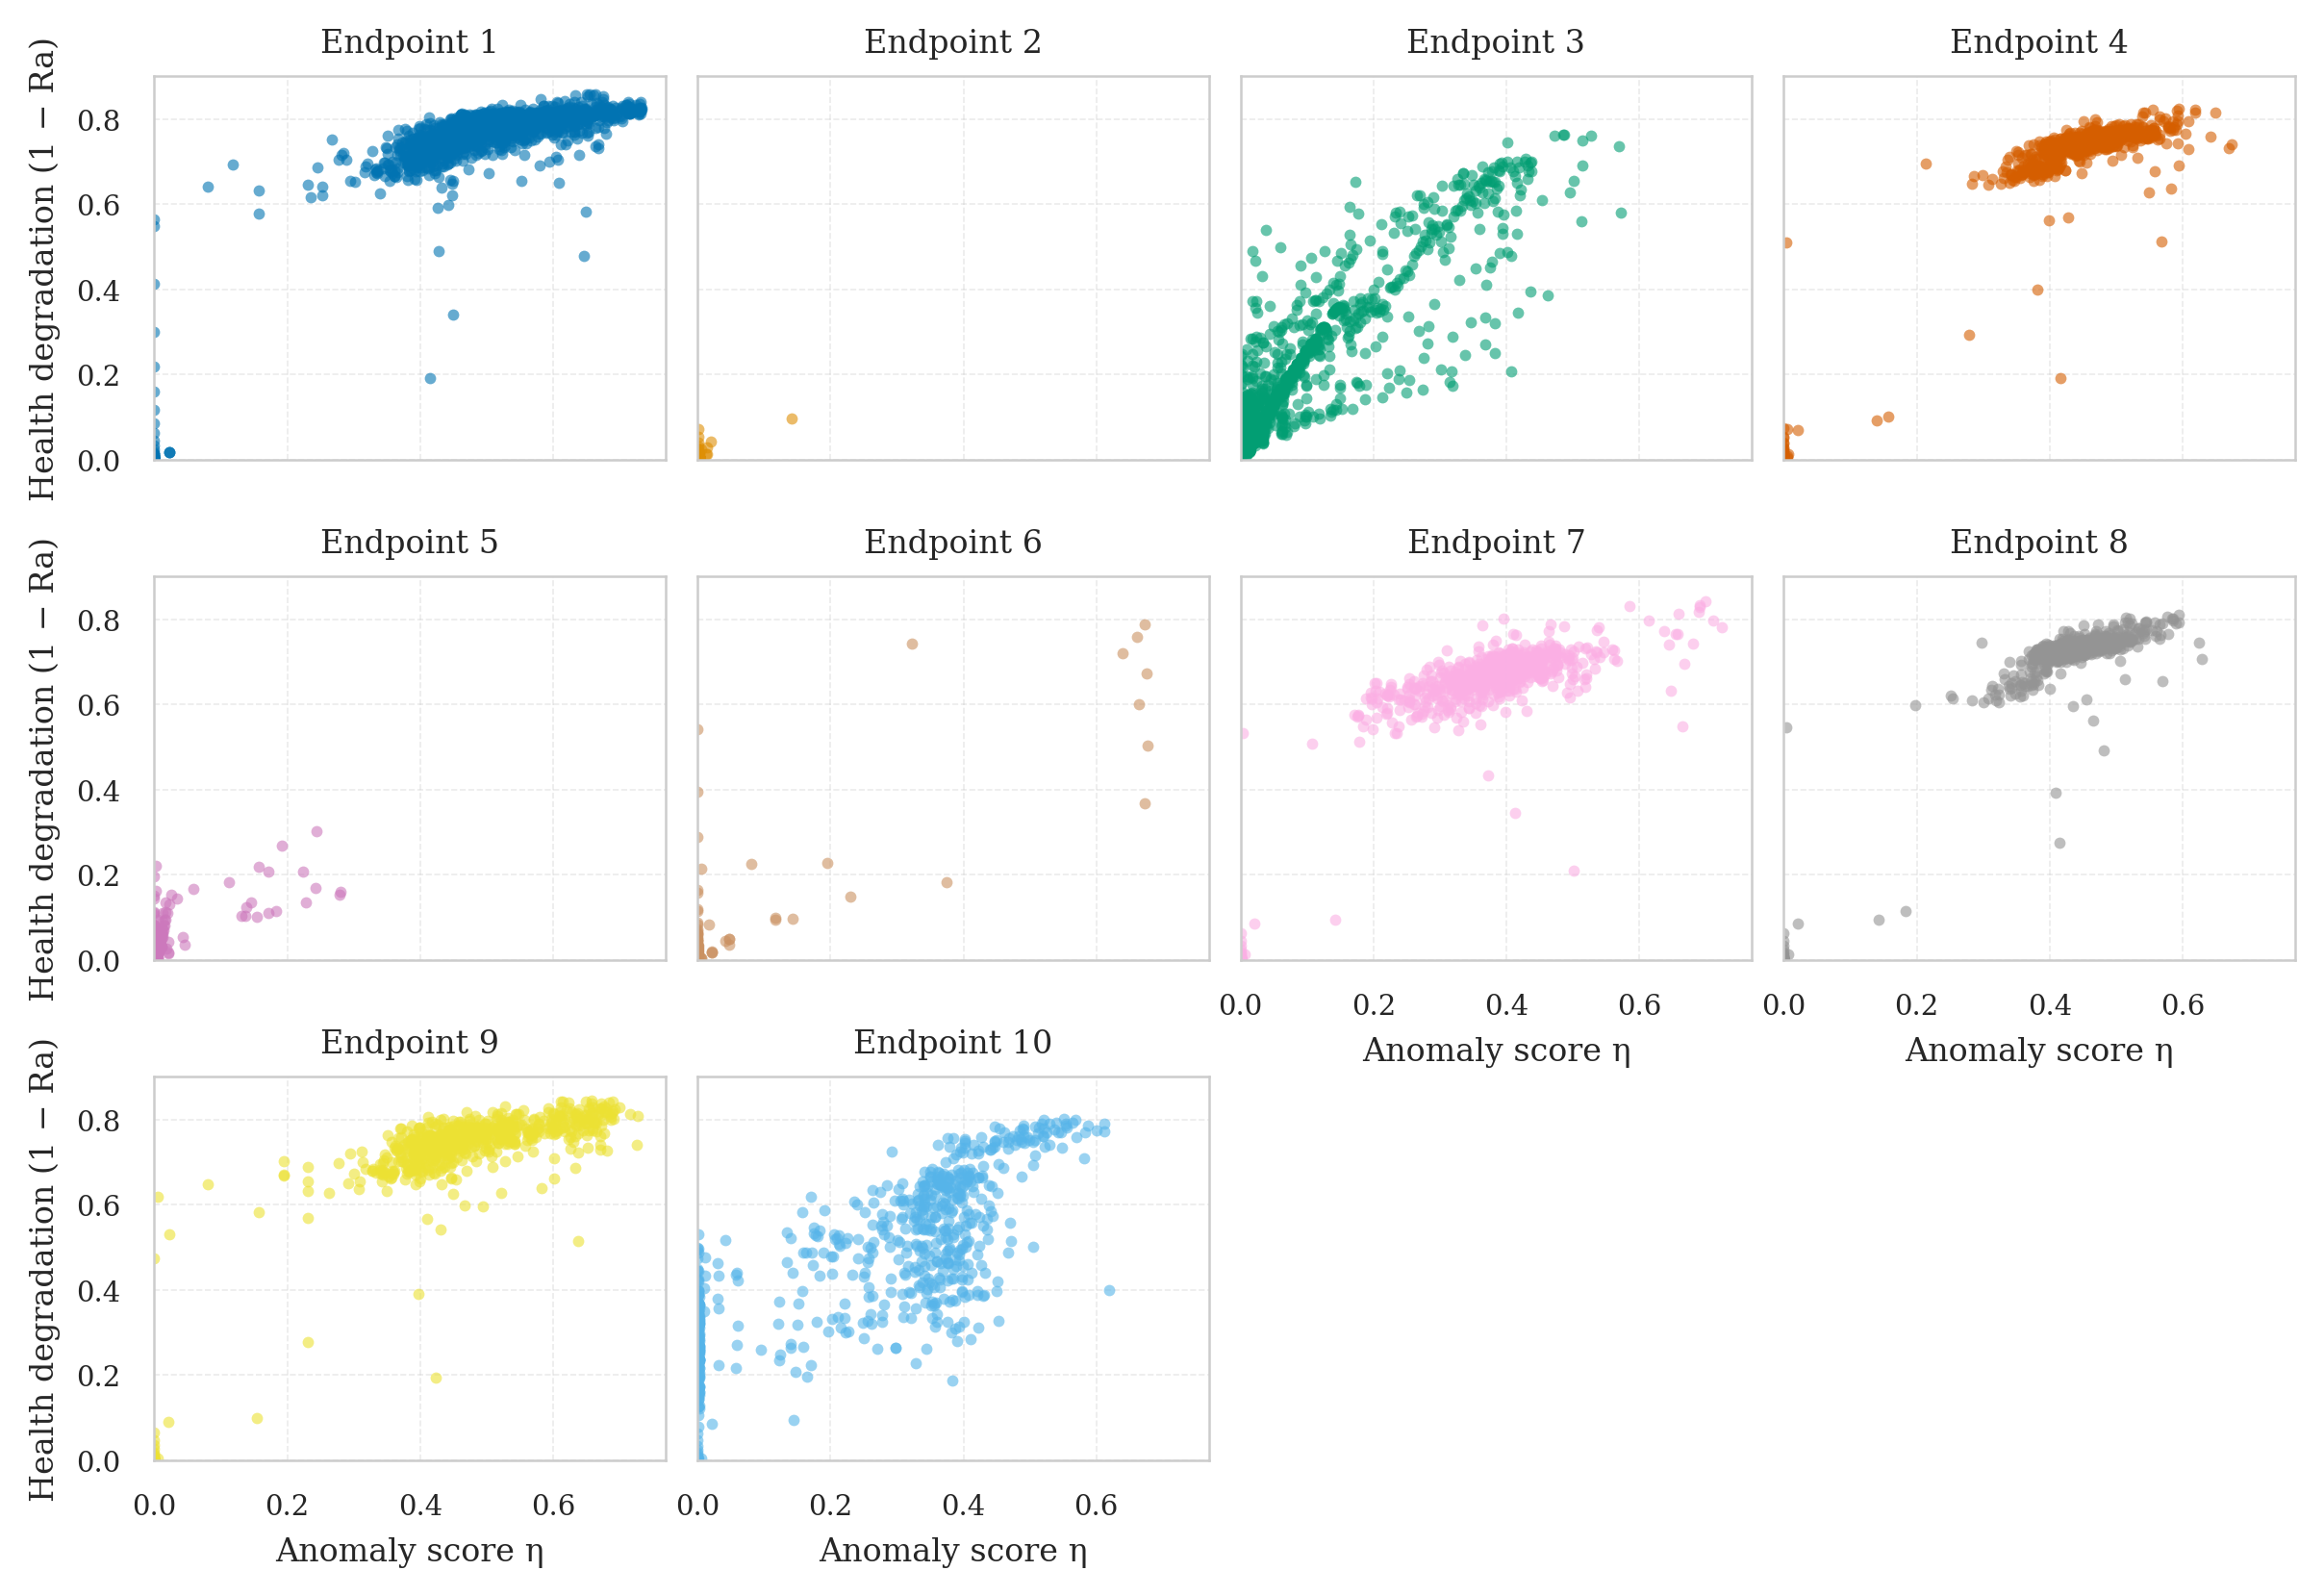

In [35]:
ra.plot_ra_vs_eta_grid(df_ra_win[df_ra_win['window_size'] == 30], col_wrap=4)

Below, it is provided a anomaly event profile of each endpoint. The anomaly frequency column states the percentage of the windows where anomaly begins, mean duration windows shows for how many windows the events happends, and total events comprises events as whole.

The anomaly analysis reveals that anomalies are rare but highly persistent across most endpoints. While the anomaly frequency is on the order of 10⁻³ events per window, the average duration reaches hundreds of windows in several endpoints, corresponding to several hours of sustained degradation. This indicates that anomalies correspond to structural state changes rather than transient fluctuations. Furthermore, the grid analysis shows a consistent monotonic relationship between anomaly score and degradation, confirming that η reliably captures persistent degradation regimes. Endpoint 10 exhibits a different behavior, with more frequent but shorter anomalies, suggesting higher volatility rather than sustained degradation.

In [36]:
summary = ra.build_anomaly_summary_table(df_ra_win[df_ra_win['window_size'] == 30])
summary

,endpoint,anomaly_frequency,mean_duration_windows,total_events,total_windows
0,Endpoint 1,0.000970,551.333333,3,3092
1,Endpoint 2,0.000647,1.000000,2,3092
2,Endpoint 3,0.000323,1.000000,1,3092
3,Endpoint 4,0.001940,104.000000,6,3092
4,Endpoint 5,0.000970,1.333333,3,3092
5,Endpoint 6,0.000647,5.500000,2,3092
6,Endpoint 7,0.001294,154.750000,4,3092
7,Endpoint 8,0.000970,207.000000,3,3092
8,Endpoint 9,0.000970,207.333333,3,3092
9,Endpoint 10,0.021992,8.000000,68,3092


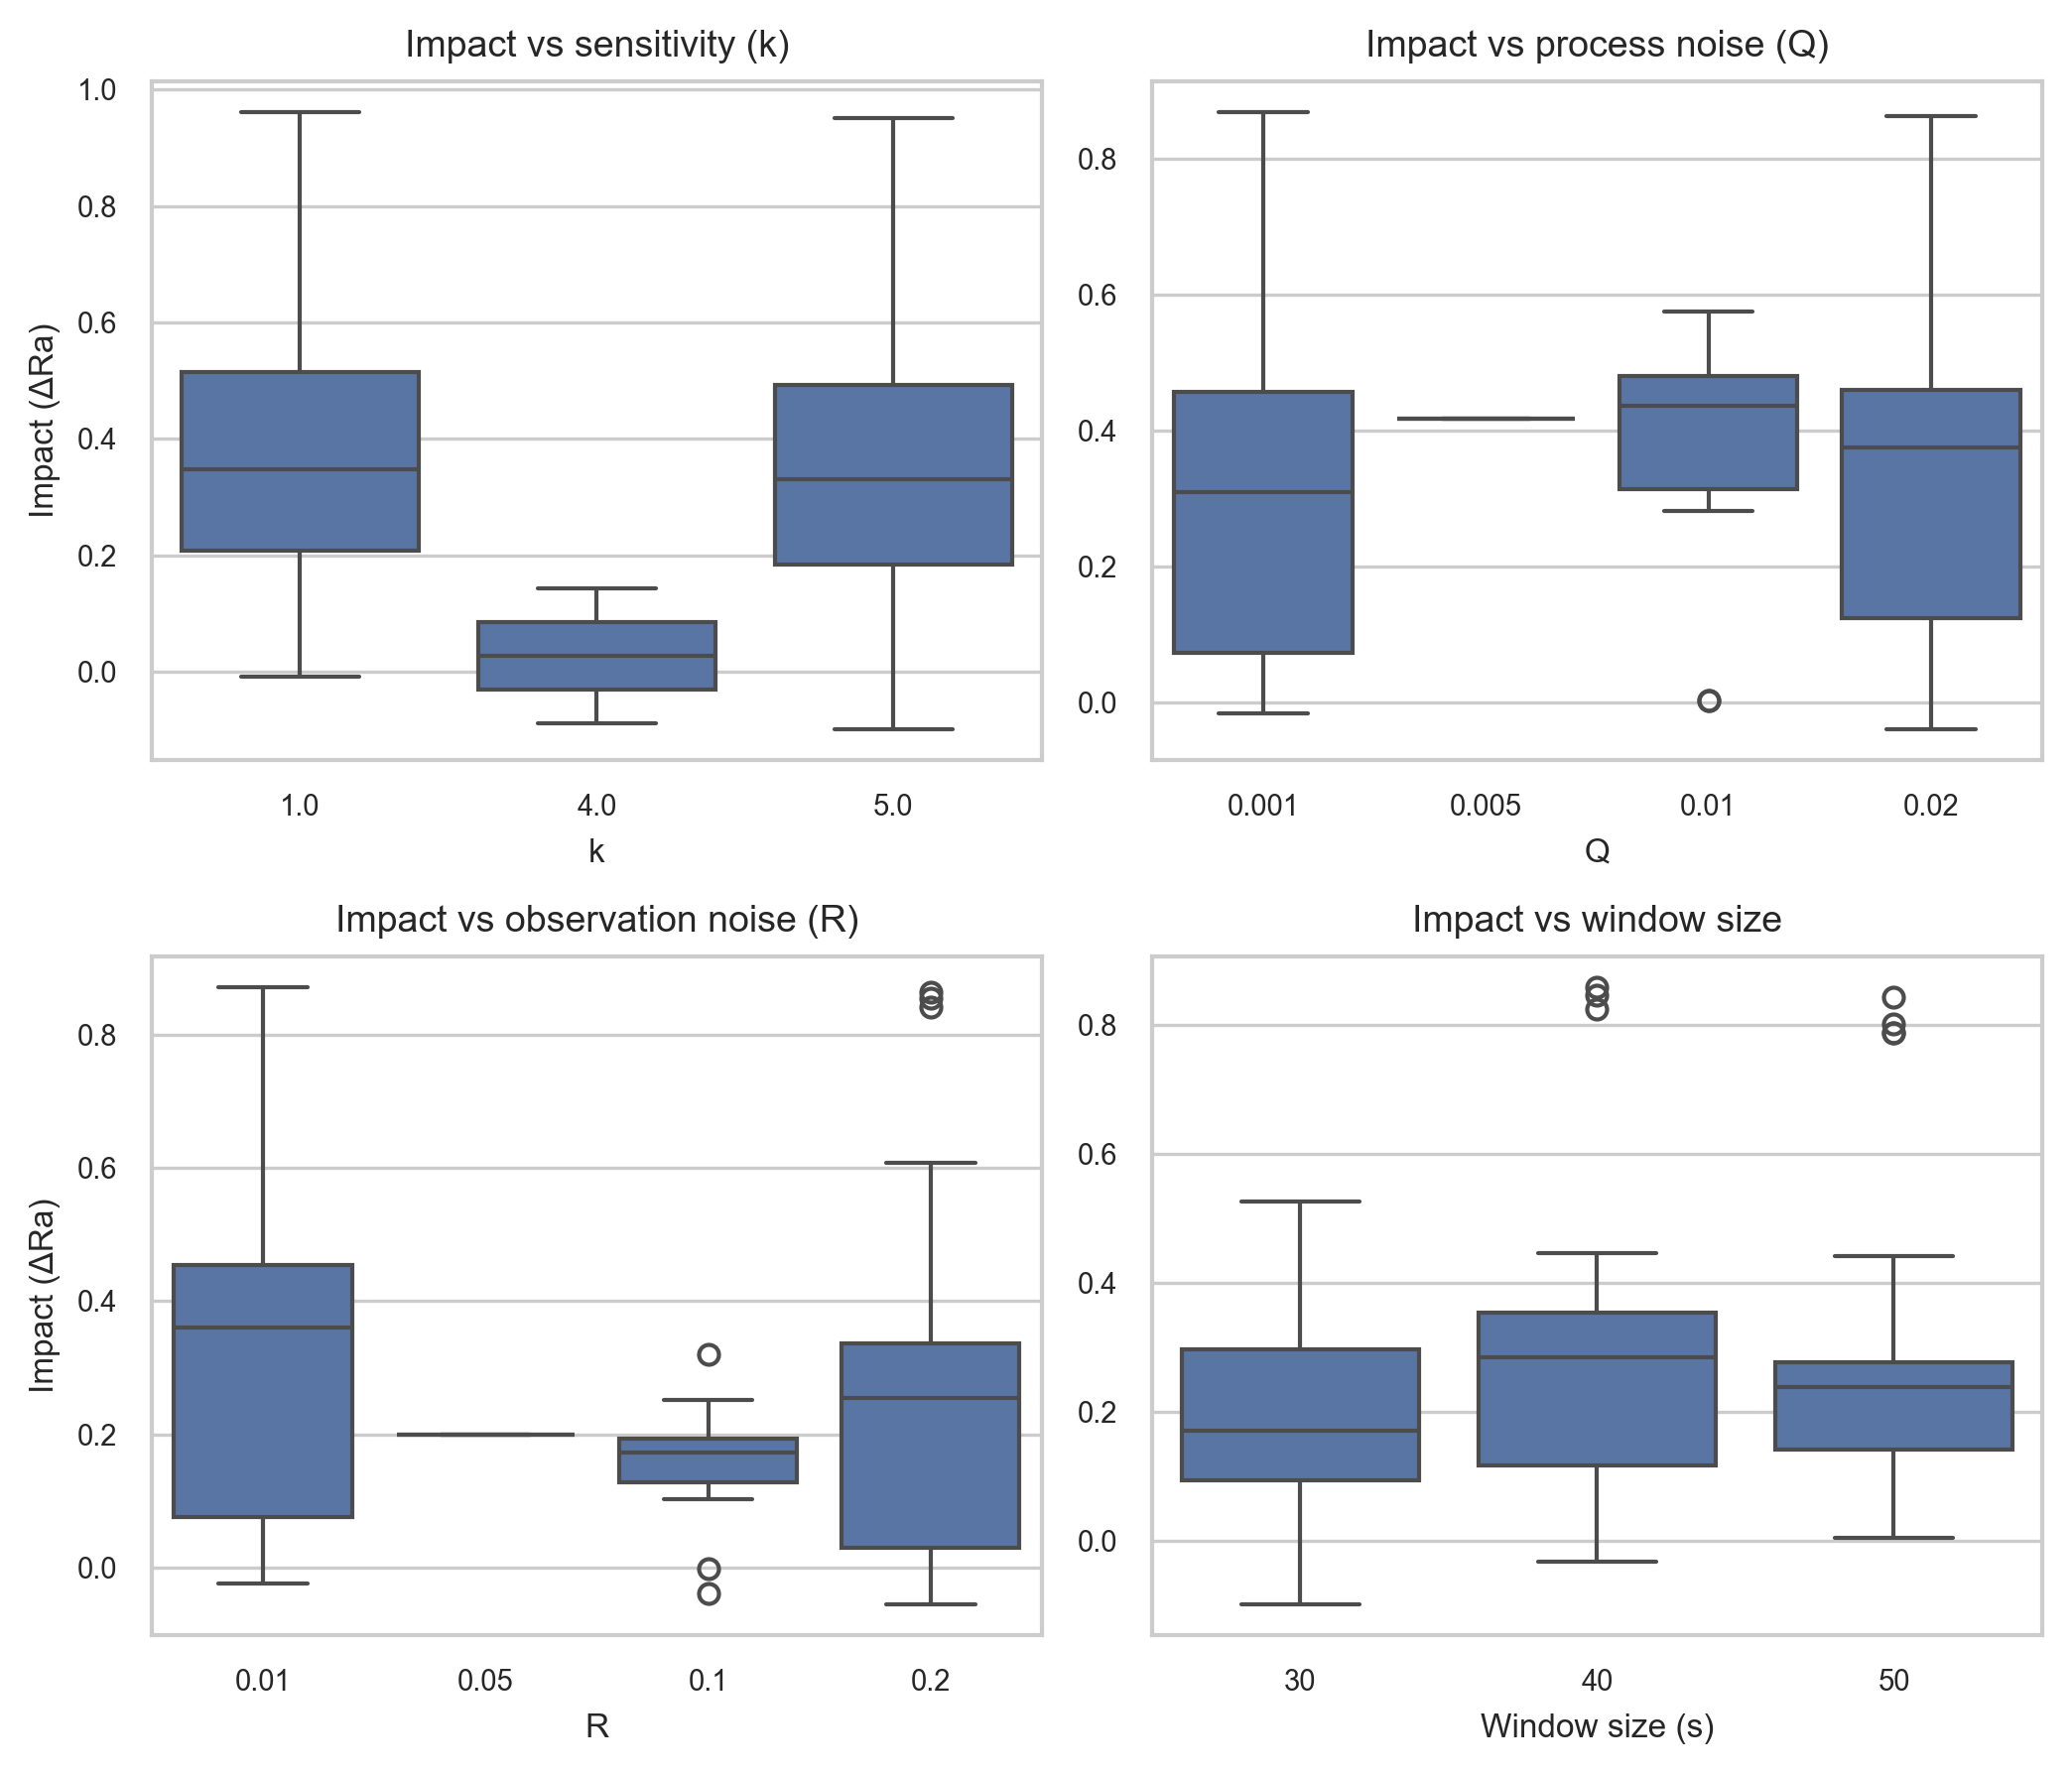

In [51]:
events_k = ra.extract_event_impacts(df_k)
events_Q = ra.extract_event_impacts(df_q)
events_R = ra.extract_event_impacts(df_r)
events_window = ra.extract_event_impacts(df_ra_win)
ra.plot_event_impact_grid(events_k, events_Q, events_R, events_window, figsize=(7,6))

The results demonstrate that the Kalman-based health indicator exhibits stable behavior across a wide range of process and observation noise parameters, while allowing sensitivity tuning through the observation sensitivity parameter k. This confirms the robustness and interpretability of the proposed estimator.

In [39]:
summary_k = ra.build_summary_table(df_k, "k")
summary_k

,k,mean_Ra,std_Ra,mean_degradation,std_degradation
0,1.0,0.895206,0.147500,0.104794,0.147500
1,2.0,0.824178,0.244069,0.175822,0.244069
2,3.0,0.775412,0.308136,0.224588,0.308136
3,4.0,0.741463,0.351155,0.258537,0.351155
4,5.0,0.717467,0.380366,0.282533,0.380366


In [40]:
summary_q = ra.build_summary_table(df_q, "Q")
summary_q

,Q,mean_Ra,std_Ra,mean_degradation,std_degradation
0,0.001,0.775810,0.305770,0.224190,0.305770
1,0.005,0.775412,0.308136,0.224588,0.308136
2,0.010,0.775313,0.309066,0.224687,0.309066
3,0.020,0.775242,0.310015,0.224758,0.310015


In [41]:
summary_r = ra.build_summary_table(df_r, "R")
summary_r

,R,mean_Ra,std_Ra,mean_degradation,std_degradation
0,0.01,0.775213,0.310338,0.224787,0.310338
1,0.05,0.775412,0.308136,0.224588,0.308136
2,0.10,0.775572,0.307160,0.224428,0.307160
3,0.20,0.775809,0.306083,0.224191,0.306083


In [42]:
summary_window = ra.build_summary_table(df_ra_win, "window_size")
summary_window

,window_size,mean_Ra,std_Ra,mean_degradation,std_degradation
0,30,0.879180,0.260741,0.120820,0.260741
1,40,0.877346,0.260541,0.122654,0.260541
2,50,0.875583,0.260880,0.124417,0.260880


Below, the chart shows the relationship between anomaly persistence and frequency across endpoints. Two distinct regimes emerge: persistent degradation, characterized by long anomaly durations and low frequency, and intermittent instability, characterized by short but frequent anomalies. Persistent regimes exhibit higher health degradation, confirming that sustained anomalies have a stronger impact on system health.

In [43]:
summary = ra.build_event_summary(df_ra_win[df_ra_win['window_size'] == 30])

In [44]:
ra.plot_regimes_plotly_clean_with_labels_right(summary, radius_offset=9)

In [45]:
ra_metrics = ra.compute_ra_classification_metrics(df_ra_win)

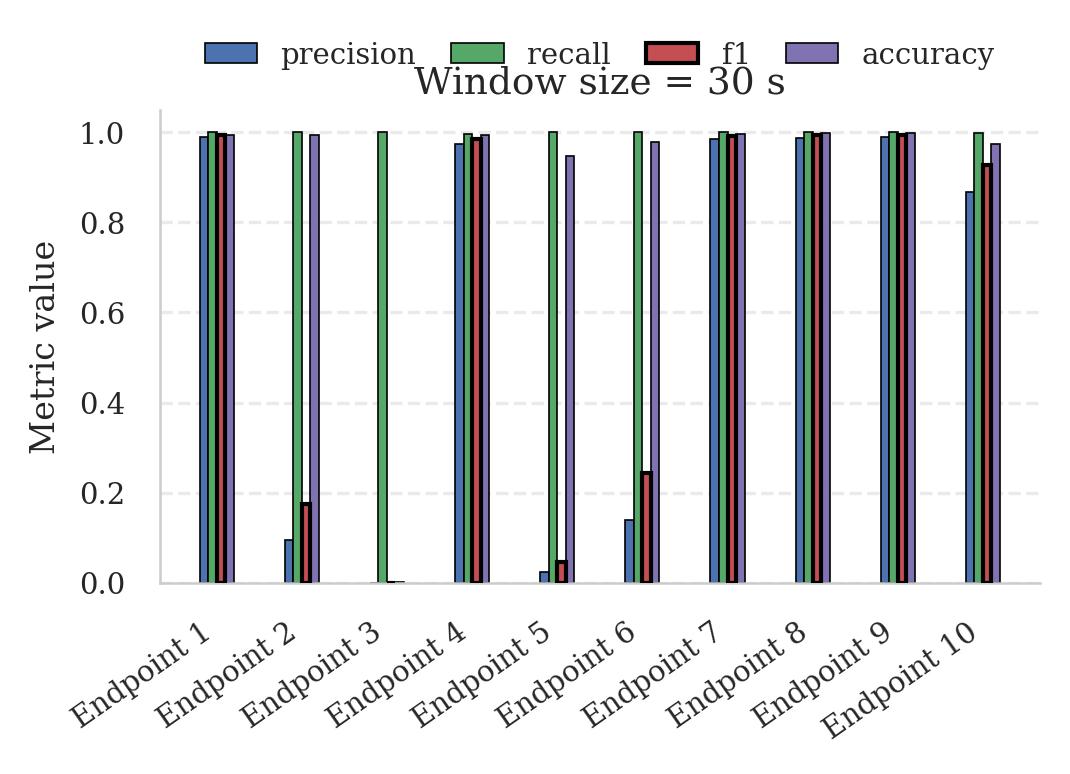

In [46]:
ra.plot_classification_metrics_bar(ra_metrics, window_size=30)

group 1 - high precision and sensitiviy:
- Endpoint 1
- Endpoint 4
- Endpoint 7
- Endpoint 8
- Endpoint 9

characteristics:
- precision ≈ 0.97–0.99
- recall ≈ 1.0
- f1 ≈ 0.98–0.99
- accuracy ≈ 0.99–1.0

group 2 - high FP:
- Endpoint 2
- Endpoint 5
- Endpoint 6

characteristics:
- precision ≈ 0.02–0.14
- recall ≈ 1.0
- f1 ≈ 0.98–0.99

group 3 - outlier:
- Endpoint 3

group 4 - high variation:
- En

In [47]:
ra.plot_results(3, df_ra_win[df_ra_win['window_size'] == 30], anomalous_traffic_win_observations_df[anomalous_traffic_win_observations_df['window_size'] == 30])

greatest anomaly at:2019-04-25 01:24:00 - begin plot:2019-04-25 01:14:00 - end plot:2019-04-25 01:54:00


greatest anomaly at:2019-04-25 14:49:30 - begin plot:2019-04-25 14:39:30 - end plot:2019-04-25 15:19:30


greatest anomaly at:2019-04-24 18:13:30 - begin plot:2019-04-24 18:03:30 - end plot:2019-04-24 18:43:30


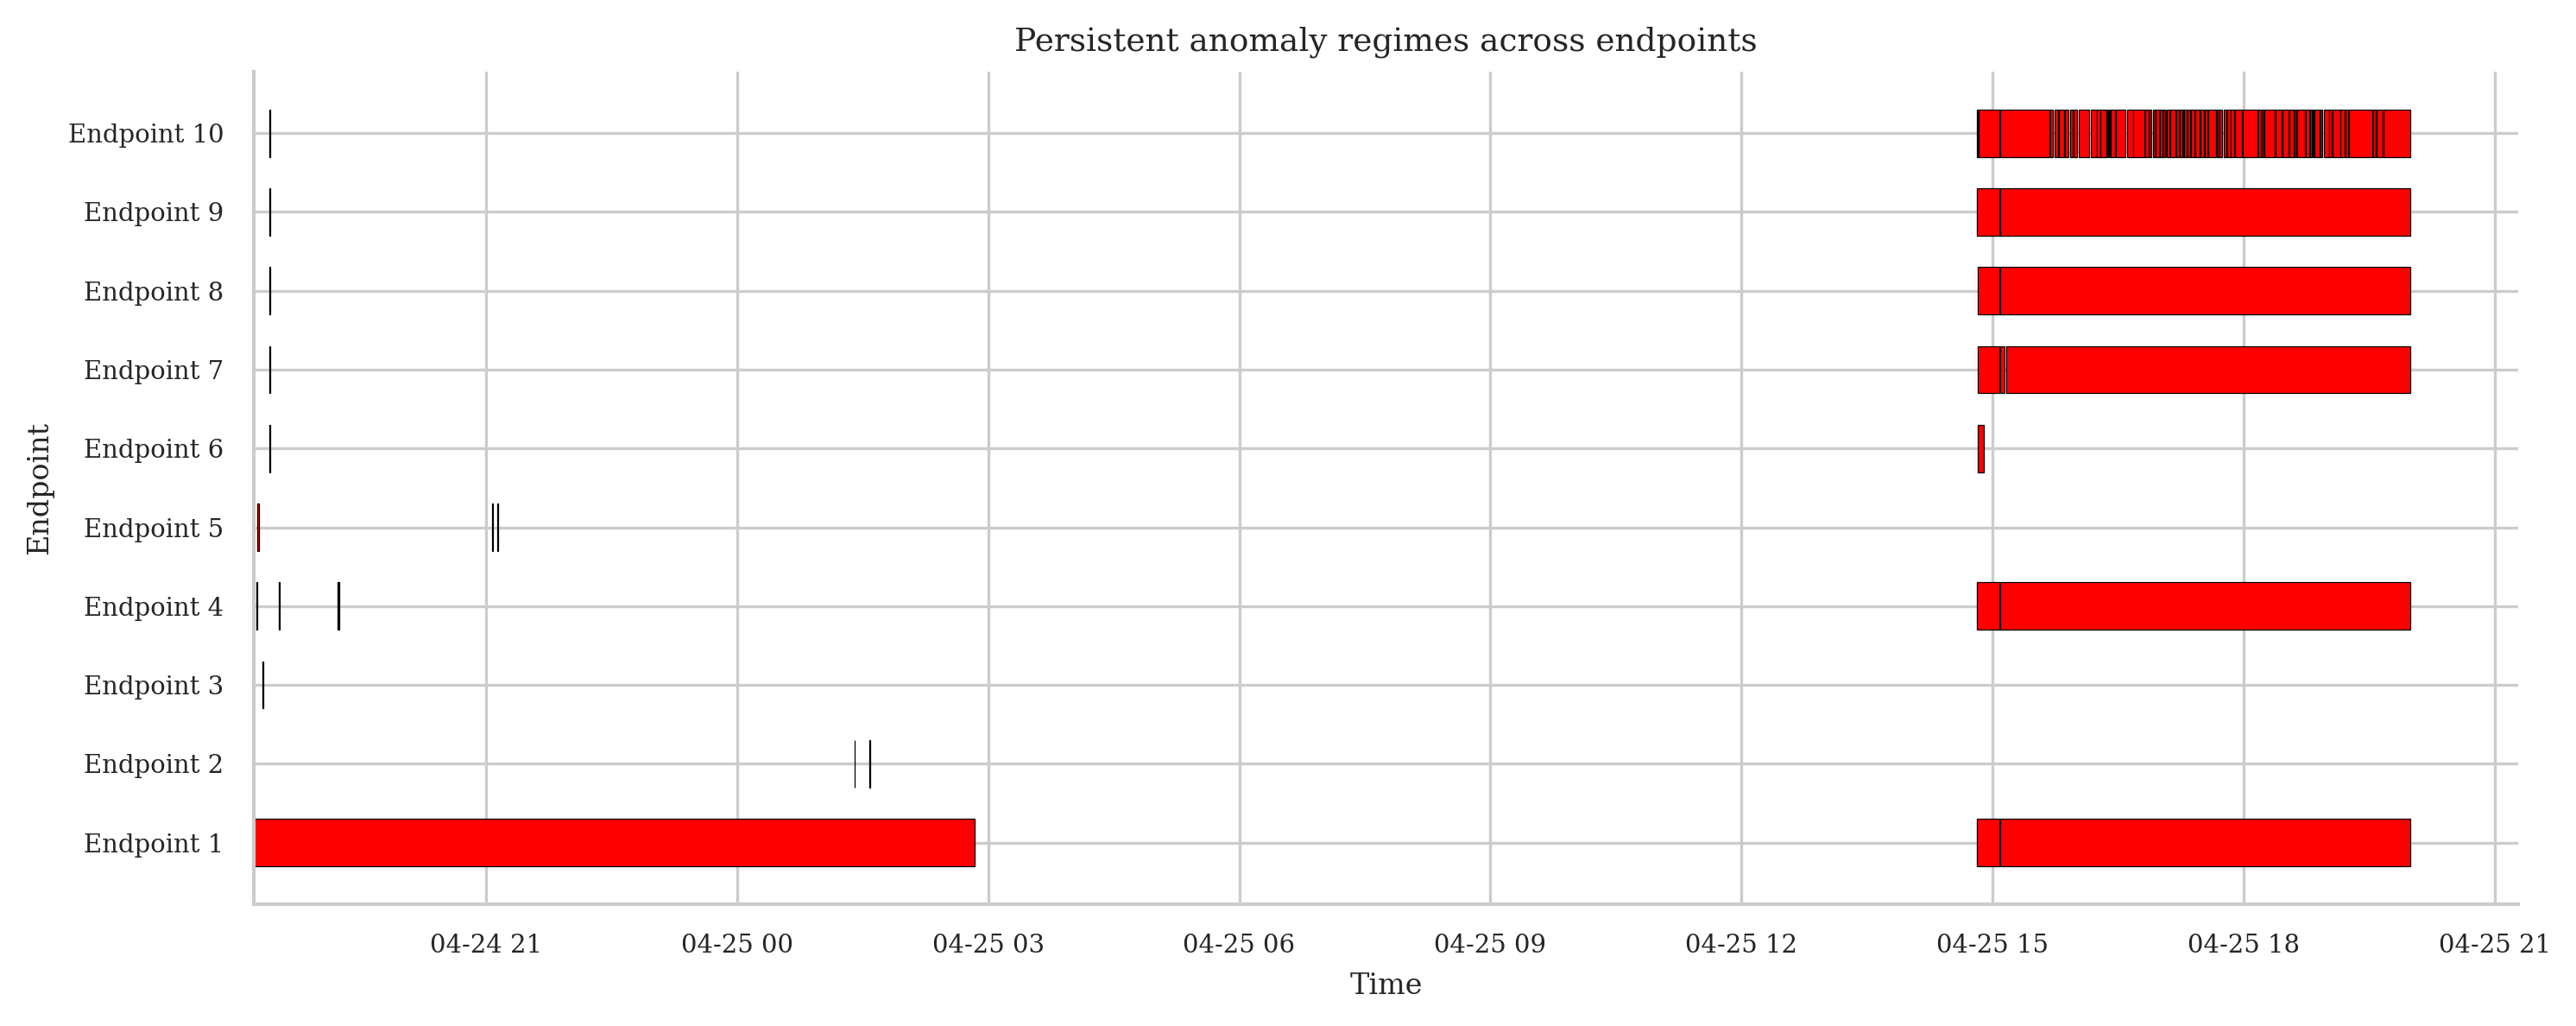

Rendered 95 anomaly blocks


In [48]:
ra.plot_anomaly_timeline_seaborn(df_ra_win[df_ra_win['window_size'] == 30])